# Capstone Project - A Reasonable Location for a New Bookstore in Greater Melbourne

The codes for the project are divided into several parts to fulfill different functions and support the project.

## Part 3, Machine Learning

The codes in Part 3 were to:
1. Use each LGA as the center of the area of interest, calculate the number of bookstore within the radius of interest and the distance of the closest bookstore to the center
2. Calculate the density of bookstores based on population and land area
3. Plot results and perform correlation studies

### 3.1 Data processing and calculation

#### Import modules

In [1]:
#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import pandas as pd
import folium 
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from math import radians, cos, sin, asin, sqrt, log
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing


#### Load dataframe of city Melbourne

In [2]:
df_city=pd.read_csv('city_melbourne.csv')
num_city=df_city.shape[0]
print(num_city)
df_city.head()


31


,LocalGovernmentArea,CouncilSeat,Region,LandArea,Population,Latitude,Longitude
0,City of Melbourne,Melbourne,Inner Melbourne,37.0,169961,-37.814218,144.963161
1,City of Port Phillip,St Kilda,Inner Melbourne,21.0,113200,-37.863826,144.981637
2,City of Stonnington,Malvern,Inner Melbourne,26.0,116207,-37.857609,145.035067
3,City of Yarra,Richmond,Inner Melbourne,20.0,98521,-37.820396,145.002515
4,City of Banyule,Greensborough,Metropolitan Melbourne,63.0,130237,-37.704028,145.108216


#### Load dataframe of bookstores

In [3]:
df_bookstore=pd.read_csv('city_melbourne_bookstore.csv')
num_bookstore=df_bookstore.shape[0]
print(num_bookstore)
df_bookstore.head()

1072


,name,categories,address,lat,lng,distance,city
0,Federation Square Book Market,Bookstore,Federation Square,-37.817229,144.969340,638,Melbourne
1,The Book Grocer,Bookstore,455 Bourke Street,-37.815270,144.960540,258,Melbourne
2,The Book Grocer,Bookstore,287 Little Collins St,-37.814927,144.965139,191,Melbourne
3,The Book Grocer,Bookstore,165 Swanston Street,-37.813913,144.965694,225,Melbourne
4,Book Grocer,Bookstore,206 Bourke St,-37.812910,144.967020,369,Melbourne


#### Create a new dataframe to store machine learning results

In [4]:
df_city_bookstore=df_city.copy(deep=True)
df_city_bookstore['NumBS']=0
df_city_bookstore['DenBSPopu']=0
df_city_bookstore['DenBSArea']=0
df_city_bookstore['CloestBSDist']=0
df_city_bookstore.head()


,LocalGovernmentArea,CouncilSeat,Region,LandArea,Population,Latitude,Longitude,NumBS,DenBSPopu,DenBSArea,CloestBSDist
0,City of Melbourne,Melbourne,Inner Melbourne,37.0,169961,-37.814218,144.963161,0,0,0,0
1,City of Port Phillip,St Kilda,Inner Melbourne,21.0,113200,-37.863826,144.981637,0,0,0,0
2,City of Stonnington,Malvern,Inner Melbourne,26.0,116207,-37.857609,145.035067,0,0,0,0
3,City of Yarra,Richmond,Inner Melbourne,20.0,98521,-37.820396,145.002515,0,0,0,0
4,City of Banyule,Greensborough,Metropolitan Melbourne,63.0,130237,-37.704028,145.108216,0,0,0,0


#### The following codes were to fulfill sevral tasks:
1. Using each LGA as the local center, calculat the distance from each bookstore to the LGA center (line distance)
2. Based on the defined area of interest, count the number of bookstore within the circle
3. Calculate the bookstore density based on population and land area
3. Identify the closest bookstore to each LGA based on the line distance

In [5]:
# function to calculate the line distance between two geo coordinates
def haversine(lng1, lat1, lng2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
 
    # haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # km
    return c * r * 1000 # m

# define a circle as area of interest
Interested_Dist=2000 # m

# run the calculation for each LGA and each bookstore
for i in range (0, num_city-1):
    num_of_bookstore=0
    city_population=df_city.at[i,'Population']
    city_area=df_city.at[i,'LandArea']
    city_lat=df_city.at[i,'Latitude']
    city_lng=df_city.at[i,'Longitude']
    NumofBookstore=0
    CloestBookstoreDist=1000000 # m
    for j in range (0,num_bookstore-1):
        bookstore_lat=df_bookstore.at[j,'lat']
        bookstore_lng=df_bookstore.at[j,'lng']
        bookstore_dist=haversine(city_lng,city_lat,bookstore_lng,bookstore_lat)
        #print(bookstore_dist)
        if bookstore_dist<=Interested_Dist:
            NumofBookstore=NumofBookstore+1
        if bookstore_dist<CloestBookstoreDist:
            CloestBookstoreDist=bookstore_dist
    DenofBookstorePopu=NumofBookstore/city_population
    DenofBookstoreArea=NumofBookstore/city_area
    df_city_bookstore.loc[i,('NumBS')]=NumofBookstore
    df_city_bookstore.loc[i,('DenBSPopu')]=DenofBookstorePopu*10000 # convert to desity per 10,000 population
    df_city_bookstore.loc[i,('DenBSArea')]=DenofBookstoreArea
    df_city_bookstore.loc[i,('CloestBSDist')]=CloestBookstoreDist


#### Reiew the dataframe

In [6]:
print(df_city_bookstore.info())
print(df_city_bookstore.describe())
df_city_bookstore.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LocalGovernmentArea  31 non-null     object 
 1   CouncilSeat          31 non-null     object 
 2   Region               31 non-null     object 
 3   LandArea             31 non-null     float64
 4   Population           31 non-null     int64  
 5   Latitude             31 non-null     float64
 6   Longitude            31 non-null     float64
 7   NumBS                31 non-null     int64  
 8   DenBSPopu            31 non-null     float64
 9   DenBSArea            31 non-null     float64
 10  CloestBSDist         31 non-null     float64
dtypes: float64(6), int64(2), object(3)
memory usage: 2.8+ KB
None
          LandArea     Population   Latitude   Longitude       NumBS  \
count    31.000000      31.000000  31.000000   31.000000   31.000000   
mean    284.967742  157640.548387 -3

,LocalGovernmentArea,CouncilSeat,Region,LandArea,Population,Latitude,Longitude,NumBS,DenBSPopu,DenBSArea,CloestBSDist
0,City of Melbourne,Melbourne,Inner Melbourne,37.0,169961,-37.814218,144.963161,349,20.534123,9.432432,11.116026
1,City of Port Phillip,St Kilda,Inner Melbourne,21.0,113200,-37.863826,144.981637,43,3.798587,2.047619,575.480841
2,City of Stonnington,Malvern,Inner Melbourne,26.0,116207,-37.857609,145.035067,4,0.344213,0.153846,734.137369
3,City of Yarra,Richmond,Inner Melbourne,20.0,98521,-37.820396,145.002515,31,3.146537,1.550000,925.733121
4,City of Banyule,Greensborough,Metropolitan Melbourne,63.0,130237,-37.704028,145.108216,6,0.460699,0.095238,386.178656


#### Plot bookstore density (population)
Please be noted that the gray circles represent the LGA with no bookstore nearby

In [7]:
latitude = df_city_bookstore.loc[0,'Latitude']
longitude = df_city_bookstore.loc[0,'Longitude']

map_melbourne = folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,CouncilSeat,DenofBookstore in zip(df_city_bookstore['Latitude'],df_city_bookstore['Longitude'],df_city_bookstore['CouncilSeat'],df_city_bookstore['DenBSPopu']):
    label = '{}'.format(CouncilSeat)
    label = folium.Popup(label, parse_html=True)
    if DenofBookstore>0:
        r_circle=15+log(DenofBookstore)
        r_color='green'
    else:
        r_circle=5
        r_color='gray'
    folium.CircleMarker(
        [lat,lng],
        radius=r_circle,
        popup=label,
        color=r_color,
        fill=True,
        fill_color=r_color,
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_melbourne)
    
map_melbourne


### 3.2 Coorelation

#### Data extraction

In [8]:
lga = df_city_bookstore['CouncilSeat']
Population = df_city_bookstore['Population']
LandArea = df_city_bookstore['LandArea']
DenBSPopu = df_city_bookstore['DenBSPopu']
DenBSArea = df_city_bookstore['DenBSArea']
CloestBSDist = df_city_bookstore['CloestBSDist']
bar_width = 0.3


#### Bar chart to show bookstore density in different LGAs

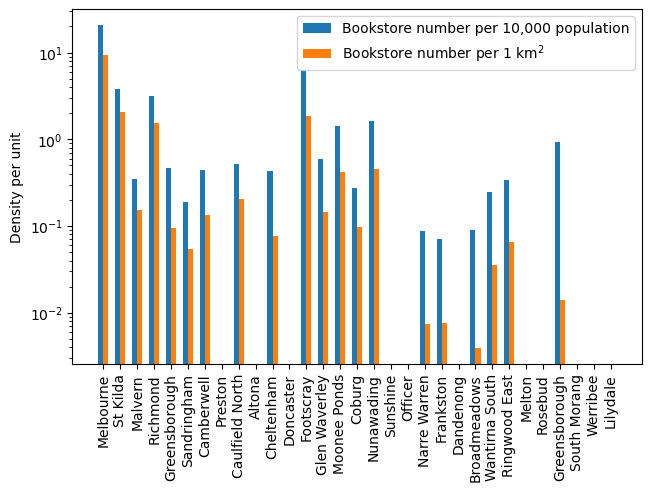

In [9]:
X = np.arange(len(lga))

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(X-bar_width/2,DenBSPopu,bar_width,label='Bookstore number per 10,000 population')
ax.bar(X+bar_width/2,DenBSArea,bar_width,label='Bookstore number per 1 km$^{2}$')

ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Density per unit')
plt.xticks(X, lga, rotation=90)

plt.show()


#### Bar chart to show the shortest bookstore distance in different LGAs

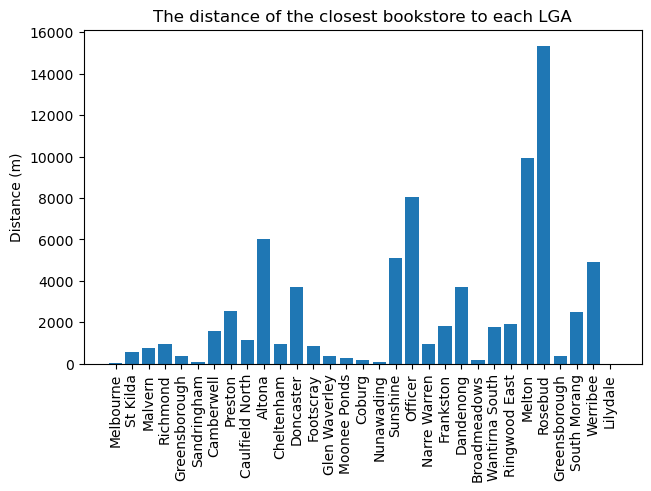

In [10]:
X = np.arange(len(lga))

fig, ax = plt.subplots(constrained_layout=True)

ax.bar(X,CloestBSDist)

ax.set_title('The distance of the closest bookstore to each LGA')
ax.set_ylabel('Distance (m)')
plt.xticks(X, lga, rotation=90)

plt.show()


#### Linear regression of the shortest bookstore distance vs. population

r_square:  0.0002371315706183319


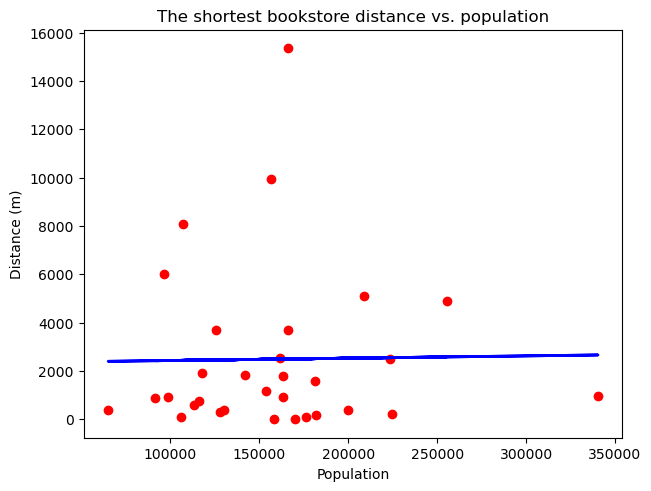

In [11]:
X=Population.values.reshape(-1,1)
y=CloestBSDist.values.reshape(-1,1)

regr = linear_model.LinearRegression()
regr = regr.fit(X, y)
y_pred = regr.predict(X)

print('r_square: ',regr.score(X, y))

# Plot outputs
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(X, y,  color='red')
ax.plot(X, y_pred, color='blue', linewidth=2)

ax.set_title('The shortest bookstore distance vs. population')
ax.set_xlabel('Population')
ax.set_ylabel('Distance (m)')

plt.show()


#### Linear regression of the shortest bookstore distance vs. bookstore density

r_square:  0.050837743503372


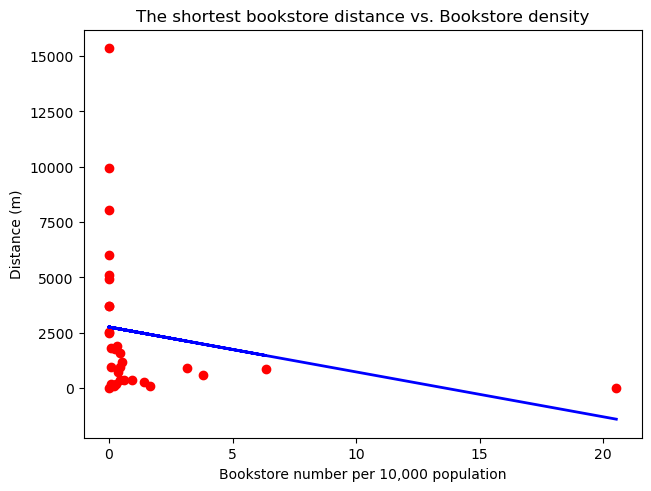

In [12]:
X=DenBSPopu.values.reshape(-1,1)
y=CloestBSDist.values.reshape(-1,1)

regr = linear_model.LinearRegression()
regr = regr.fit(X, y)
y_pred = regr.predict(X)

print('r_square: ',regr.score(X, y))

# Plot outputs
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(X, y,  color='red')
ax.plot(X, y_pred, color='blue', linewidth=2)

ax.set_title('The shortest bookstore distance vs. Bookstore density')
ax.set_xlabel('Bookstore number per 10,000 population')
ax.set_ylabel('Distance (m)')

plt.show()


### 3.3 Clustering
1. Drop all columns except Distance and Population
2. Normalized the dataframe
3. Perform K-means clustering using several different k
4. Plot clustering results

#### Data pre-processing

In [13]:
X = df_city_bookstore.drop(['LocalGovernmentArea','CouncilSeat','Region','LandArea','Latitude','Longitude','NumBS','DenBSPopu','DenBSArea'],1)
cols = X.columns

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_scaled, columns = cols)
X_normalized.head()


,Population,CloestBSDist
0,0.381228,0.000724
1,0.175183,0.037473
2,0.186098,0.047804
3,0.121897,0.060280
4,0.237028,0.025147


#### Perform K-means clustering and Plot K-means clustering results (k=2)

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1]


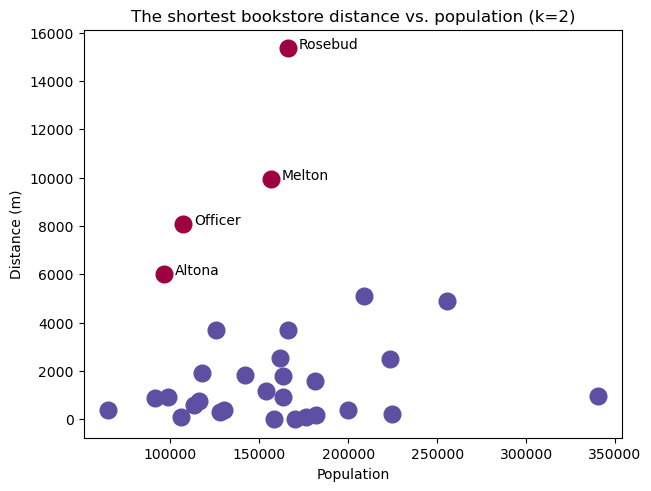

In [14]:
k=2

k_means = KMeans(init = "k-means++", n_clusters = k)
k_means.fit(X_normalized)

k_means_labels = k_means.labels_
print(k_means_labels)


# Plot outputs
fig, ax = plt.subplots(constrained_layout=True)

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

i=0

for Population, CloestBSDist in zip(X['Population'],X['CloestBSDist']):
    col=colors[k_means_labels[i]]
    ax.plot(Population, CloestBSDist, c=col, marker='o', markersize=12)
    if (k_means_labels[i]==k_means_labels[26]):
        ax.text(Population+6000, CloestBSDist, df_city_bookstore.loc[i,'CouncilSeat'])
    i=i+1

ax.set_title('The shortest bookstore distance vs. population (k=2)')
ax.set_xlabel('Population')
ax.set_ylabel('Distance (m)')

plt.show()


#### Perform K-means clustering and Plot K-means clustering results (k=3)

[0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 2 1 2 0 0 2 0 0 1 1 0 2 2 0]


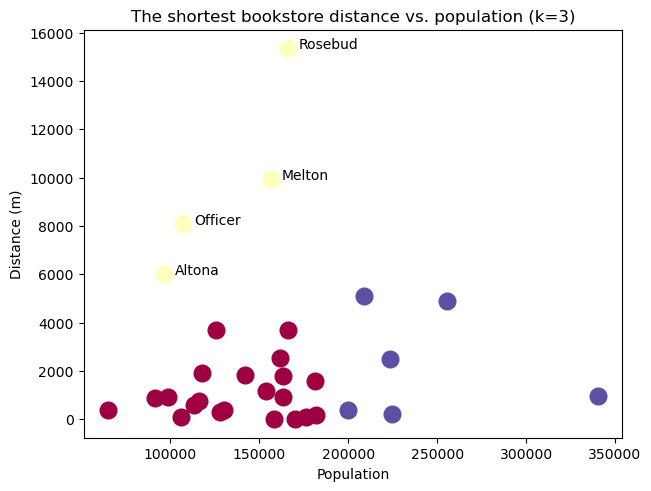

In [15]:
k=3

k_means = KMeans(init = "k-means++", n_clusters = k)
k_means.fit(X_normalized)

k_means_labels = k_means.labels_
print(k_means_labels)


# Plot outputs
fig, ax = plt.subplots(constrained_layout=True)

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

i=0

for Population, CloestBSDist in zip(X['Population'],X['CloestBSDist']):
    col=colors[k_means_labels[i]]
    ax.plot(Population, CloestBSDist, c=col, marker='o', markersize=12)
    if (k_means_labels[i]==k_means_labels[26]):
        ax.text(Population+6000, CloestBSDist, df_city_bookstore.loc[i,'CouncilSeat'])
    i=i+1

ax.set_title('The shortest bookstore distance vs. population (k=3)')
ax.set_xlabel('Population')
ax.set_ylabel('Distance (m)')

plt.show()


#### Perform K-means clustering and Plot K-means clustering results (k=4)

[0 2 2 2 2 2 0 0 0 2 0 2 2 0 2 0 0 3 1 3 2 0 0 0 2 1 1 2 3 3 0]


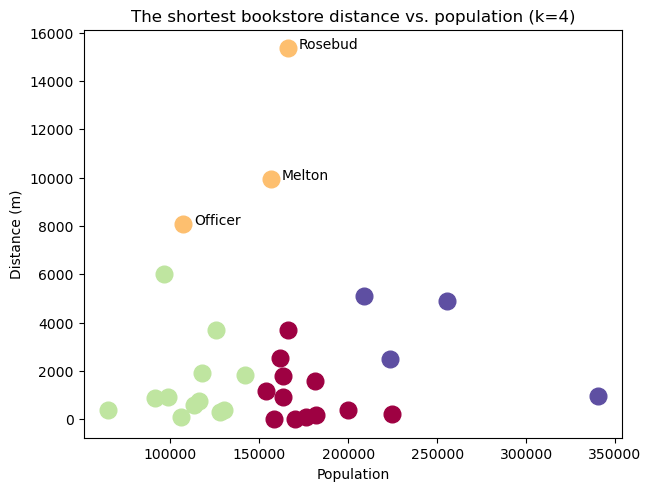

In [16]:
k=4

k_means = KMeans(init = "k-means++", n_clusters = k)
k_means.fit(X_normalized)

k_means_labels = k_means.labels_
print(k_means_labels)


# Plot outputs
fig, ax = plt.subplots(constrained_layout=True)

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

i=0

for Population, CloestBSDist in zip(X['Population'],X['CloestBSDist']):
    col=colors[k_means_labels[i]]
    ax.plot(Population, CloestBSDist, c=col, marker='o', markersize=12)
    if (k_means_labels[i]==k_means_labels[26]):
        ax.text(Population+6000, CloestBSDist, df_city_bookstore.loc[i,'CouncilSeat'])
    i=i+1

ax.set_title('The shortest bookstore distance vs. population (k=4)')
ax.set_xlabel('Population')
ax.set_ylabel('Distance (m)')

plt.show()


#### Perform K-means clustering and Plot K-means clustering results (k=5)

[0 2 2 2 2 2 0 0 0 4 0 2 2 0 2 0 0 3 4 3 2 0 0 0 2 4 1 2 3 3 0]


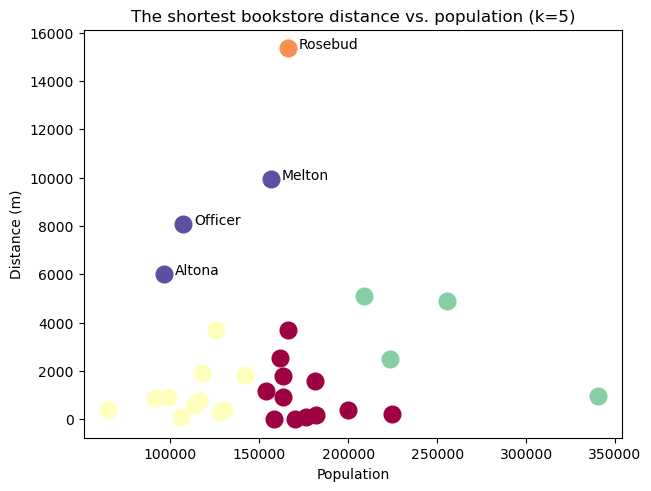

In [17]:
k=5

k_means = KMeans(init = "k-means++", n_clusters = k)
k_means.fit(X_normalized)

k_means_labels = k_means.labels_
print(k_means_labels)


# Plot outputs
fig, ax = plt.subplots(constrained_layout=True)

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

i=0

for Population, CloestBSDist in zip(X['Population'],X['CloestBSDist']):
    col=colors[k_means_labels[i]]
    ax.plot(Population, CloestBSDist, c=col, marker='o', markersize=12)
    if (k_means_labels[i]==k_means_labels[26]):
        ax.text(Population+6000, CloestBSDist, df_city_bookstore.loc[i,'CouncilSeat'])
    if (k_means_labels[i]==k_means_labels[9]):
        ax.text(Population+6000, CloestBSDist, df_city_bookstore.loc[i,'CouncilSeat'])
    i=i+1

ax.set_title('The shortest bookstore distance vs. population (k=5)')
ax.set_xlabel('Population')
ax.set_ylabel('Distance (m)')

plt.show()
